In [ ]:
# import sys
# import os

In [ ]:
# Add the absolute path to the `iTransformer/model` directory at the start of sys.path
# sys.path.insert(0, os.path.abspath("iTransformer"))

In [ ]:
# import torch
# import numpy as np
# from iTransformer.model.iTransformer import Model

In [ ]:
# # Define configuration settings
# class Configs:
#     def __init__(self):
#         self.seq_len = 30          # Input sequence length (e.g., 30 days)
#         self.pred_len = 7          # Prediction length (e.g., forecast next 7 days)
#         self.d_model = 64          # Dimension of the model
#         self.embed = 'timeF'       # Embedding type for time features
#         self.freq = 'd'            # Daily frequency for electricity data
#         self.dropout = 0.1         # Dropout rate
#         self.e_layers = 2          # Number of encoder layers
#         self.n_heads = 4           # Number of attention heads
#         self.d_ff = 128            # Feedforward dimension
#         self.activation = 'relu'   # Activation function
#         self.output_attention = False
#         self.use_norm = True
#         self.class_strategy = None # Additional class settings (adjust as needed)
#         self.factor = 5            # Scaling factor for attention (set according to model needs)


# configs = Configs()

# # Instantiate the model
# model = Model(configs)

In [ ]:
# # Dummy data preparation (replace with actual electricity price data)
# batch_size = 1
# n_features = 1  # For univariate data (single electricity price series)

In [ ]:
# # Create dummy data for input and timestamp embeddings
# x_enc = torch.rand(batch_size, configs.seq_len, n_features)  # Encoder input
# x_mark_enc = torch.rand(batch_size, configs.seq_len, n_features)  # Encoder timestamps
# x_dec = torch.rand(batch_size, configs.pred_len, n_features)  # Decoder input
# x_mark_dec = torch.rand(batch_size, configs.pred_len, n_features)  # Decoder timestamps

In [ ]:
# # Perform forecasting
# model.eval()  # Set model to evaluation mode for inference
# with torch.no_grad():
#     output = model(x_enc, x_mark_enc, x_dec, x_mark_dec)

# # Display forecasted values
# print("Forecasted electricity prices:", output.squeeze().numpy())

In [ ]:
# Lets try to fit a iTransformer on my data

In [52]:
import pandas as pd

# Load the data
file_path = 'time_series_jan_feb.xlsx'
df = pd.read_excel(file_path)

# Check the data structure
print(df.head())

             start_date             end_date  Germany/Luxembourg [€/MWh]
0  Jan 1, 2024 12:00 AM  Jan 1, 2024 1:00 AM                        0.10
1   Jan 1, 2024 1:00 AM  Jan 1, 2024 2:00 AM                        0.01
2   Jan 1, 2024 2:00 AM  Jan 1, 2024 3:00 AM                        0.00
3   Jan 1, 2024 3:00 AM  Jan 1, 2024 4:00 AM                       -0.01
4   Jan 1, 2024 4:00 AM  Jan 1, 2024 5:00 AM                       -0.03


In [53]:
# Assuming 'timestamp' is the time column and 'price' is the target
df['start_date'] = pd.to_datetime(df['start_date'])
df = df.sort_values(by='start_date').reset_index(drop=True)

# Extract just the hourly price data for simplicity
prices = df['Germany/Luxembourg [€/MWh]'].values

C:\Users\Patrick\AppData\Local\Temp\ipykernel_23692\87859670.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['start_date'] = pd.to_datetime(df['start_date'])


In [56]:
df['hour'] = df['start_date'].dt.hour  # Hour of the day
hours = df['hour'].values

In [58]:
import torch
import numpy as np

# Define sequences for the model
seq_len = 24  # Input sequence length (last 24 hours)
pred_len = 24  # Forecast length (next 24 hours)

In [68]:
# Create sequences of input and output pairs
x_data = []
y_data = []
for i in range(len(prices) - seq_len - pred_len):
    x_prices = prices[i:i + seq_len]
    x_hours = hours[i:i + seq_len]
    
    # Combine prices and hour features (e.g., as tuples or concatenated arrays)
    x = [[price, hour] for price, hour in zip(x_prices, x_hours)]
    
    y = prices[i + seq_len:i + seq_len + pred_len]
    x_data.append(x)
    y_data.append(y)

In [69]:
# Convert to numpy arrays and then to tensors
x_data = np.array(x_data)
y_data = np.array(y_data)

In [70]:
x_data = torch.tensor(x_data, dtype=torch.float32)
y_data = torch.tensor(y_data, dtype=torch.float32)

In [71]:
# Reshape to match model requirements: [batch_size, seq_len, n_features]
#x_data = x_data.unsqueeze(-1)  # Add a features dimension for univariate
y_data = y_data.unsqueeze(-1)

In [72]:
x_data.shape

torch.Size([1008, 24, 2])

In [73]:
y_data.shape

torch.Size([1008, 24, 1])

In [74]:
import sys
import os

In [75]:
# Add the absolute path to the `iTransformer/model` directory at the start of sys.path
sys.path.insert(0, os.path.abspath("iTransformer"))

In [76]:
from torch.utils.data import DataLoader, TensorDataset
from iTransformer.model.iTransformer import Model

In [77]:
# Define configuration settings
class Configs:
    def __init__(self):
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.d_model = 64
        self.embed = 'timeF'
        self.freq = 'h'            # Hourly frequency for data
        self.dropout = 0.1
        self.e_layers = 2
        self.n_heads = 4
        self.d_ff = 128
        self.activation = 'relu'
        self.output_attention = False
        self.use_norm = True
        self.class_strategy = None
        self.factor = 5

In [78]:
configs = Configs()
model = Model(configs)

In [79]:
# Create DataLoader for batching
batch_size = 16
train_dataset = TensorDataset(x_data, y_data)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [80]:
# Define loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training loop
model.train()
epochs = 40
for epoch in range(epochs):
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        # Forecast
        output = model(x_batch, None, None, None)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

c:\Users\Patrick\Documents\Python Scripts\python_competition\venv\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([16, 24, 1])) that is different to the input size (torch.Size([16, 24, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/10, Loss: 1864.0973
Epoch 2/10, Loss: 1245.0692
Epoch 3/10, Loss: 834.9341
Epoch 4/10, Loss: 876.4004
Epoch 5/10, Loss: 591.0779
Epoch 6/10, Loss: 532.7292
Epoch 7/10, Loss: 501.8001
Epoch 8/10, Loss: 508.9406
Epoch 9/10, Loss: 374.0793
Epoch 10/10, Loss: 495.2303


In [82]:
# Inference example (predict the next 24 hours)
model.eval()
with torch.no_grad():
    last_24_hours = torch.tensor(prices[-seq_len:], dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
    predicted_prices = model(last_24_hours, None, None, None)
    print("Predicted prices for the next 24 hours:", predicted_prices.squeeze().numpy())

Predicted prices for the next 24 hours: [ 61.469162  61.211727  61.64983   67.575     73.0616    79.91559
  87.18251   93.151566  93.65917   90.77729   91.19239   82.67075
  78.3273    80.13336   82.89842   93.57637  102.29016  109.63704
 109.0898   102.72699   99.75809   86.30739   79.873436  73.16625 ]


In [83]:
predicted_prices.size()

torch.Size([1, 24, 1])

In [84]:
# Load the validation data (assuming it’s in the same file for simplicity)
file_path = 'validation_dataset.xlsx'
validation_df = pd.read_excel(file_path)  # Adjust the sheet name if needed
validation_df['start_date'] = pd.to_datetime(validation_df['start_date'])
validation_df = validation_df.sort_values(by='start_date').reset_index(drop=True)
validation_prices = validation_df['Germany/Luxembourg [€/MWh]'].values

C:\Users\Patrick\AppData\Local\Temp\ipykernel_23692\3100871089.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  validation_df['start_date'] = pd.to_datetime(validation_df['start_date'])


In [85]:
# Prepare the validation input sequence (last 24 hours for input)
validation_input = validation_prices[:24]  # Assuming we start with the initial sequence for forecasting

In [86]:
validation_input

array([60.63, 59.34, 55.76, 54.79, 55.06, 58.43, 63.23, 72.74, 79.73,
       69.65, 63.86, 63.29, 62.63, 63.82, 69.03, 72.23, 78.54, 82.97,
       87.58, 84.47, 76.48, 69.68, 68.2 , 63.8 ])

In [87]:
validation_input = torch.tensor(validation_input, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)

In [88]:
actual_values = np.array(validation_input).flatten()

In [89]:
len(actual_values)

24

In [90]:
predicted_values = np.array(predicted_prices).flatten()

In [91]:
len(predicted_values)

24

In [92]:
import matplotlib.pyplot as plt

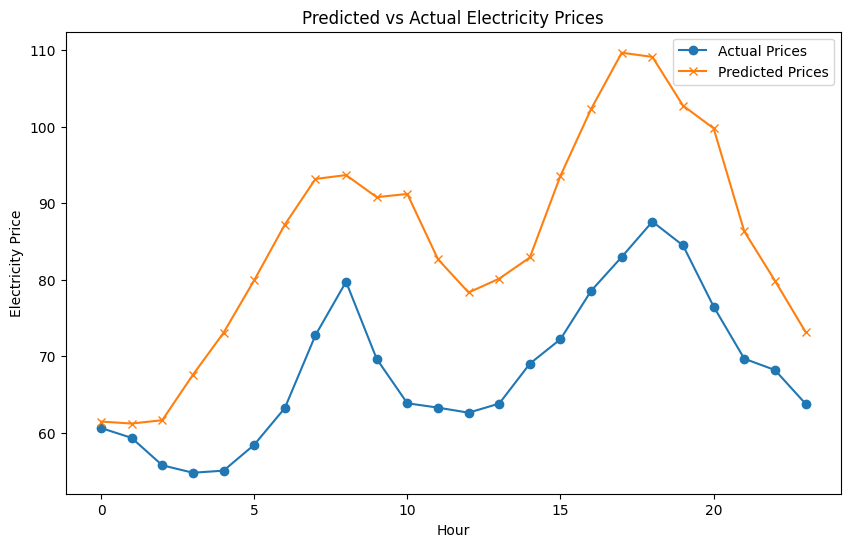

In [93]:
# Plot the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(range(len(actual_values)), actual_values, label="Actual Prices", marker='o')
plt.plot(range(len(predicted_values)), predicted_values, label="Predicted Prices", marker='x')
plt.xlabel("Hour")
plt.ylabel("Electricity Price")
plt.title("Predicted vs Actual Electricity Prices")
plt.legend()
plt.show()